In [1]:
import numpy as np
import os, requests
from src.session_metadata import Session
import os
import gc
import psutil
from pathlib import Path
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap, TwoSlopeNorm
import pandas as pd


In [2]:
# Set the current working directory
cwd = os.chdir(r"C:\Python Work Directory\NMA_Impact_Scholars_Steinmetz")

# @title Data retrieval
data_directory = r'data\spikeAndBehavioralData'

figures_directory = r'figures'

session_label_string = "Cori_2016-12-18"

session_label = session_label_string.split("_")
print(session_label)

# test_dataset
test_LFP = session_label_string

['Cori', '2016-12-18']


In [6]:
# Step 2: Extract and Visualize Data from alldat.
# Load Data
fnames = []
for j in range(1,4,1):
  fnames.append('steinmetz_part%d.npz'%j)
url = ["https://osf.io/agvxh/download"]
url.append("https://osf.io/uv3mw/download")
url.append("https://osf.io/ehmw2/download")

for j in range(len(url)):
  if not os.path.isfile(fnames[j]):
    try:
      r = requests.get(url[j])
    except requests.ConnectionError:
      print("!!! Failed to download data !!!")
    else:
      if r.status_code != requests.codes.ok:
        print("!!! Failed to download data !!!")
      else:
        with open(fnames[j], "wb") as fid:
          fid.write(r.content)

# Function to load data from npz files
def load_data(filenames):
    alldat = np.array([])
    for filename in filenames:
        data = np.load(filename, allow_pickle=True)['dat']
        alldat = np.hstack((alldat, data))
    return alldat

# Download data if not already present
alldat = load_data(fnames)

In [25]:
def get_memory_usage():
    """Return current memory usage in MB"""
    process = psutil.Process(os.getpid())
    memory_mb = process.memory_info().rss / 1024 / 1024
    return memory_mb

def log_memory(message):
    """Log a message with current memory usage"""
    memory_mb = get_memory_usage()
    print(f"{message} - Memory usage: {memory_mb:.2f} MB")

def process_files(data_directory, alldat, batch_size=10):
    log_memory("Starting process")
    result_df = pd.DataFrame()

    walker = os.walk(os.path.join(os.getcwd(), data_directory))
    all_files = []

    # First collect all valid files to process
    for _, _, files in walker:
        for file in files:
            mouse_name = Path(file).stem.split("_")[0]
            date_exp = Path(file).stem.split("_")[1]

            # Find matching data entry
            matching_dat = None
            for dat in alldat:
                if mouse_name == dat['mouse_name'] and date_exp == dat['date_exp']:
                    matching_dat = dat
                    break

            if matching_dat:
                all_files.append((file, matching_dat))

    log_memory(f"Found {len(all_files)} files to process")

    # Process files in batches
    for i in range(0, len(all_files), batch_size):
        batch = all_files[i:i+batch_size]
        batch_dfs = []

        log_memory(f"Starting batch {i//batch_size + 1}")

        for file, dat in batch:
            try:
                file_path = os.path.join(os.getcwd(), data_directory, file)
                log_memory(f"Before loading {file}")
                session = Session.from_tar(file_path)
                log_memory(f"After loading {file}")

                # Update brain area
                session.cluster_df.loc[dat['cellid_orig'], 'brain_area'] = dat['brain_area']

                # Process polar_df
                current_df = session.polar_df.reset_index().merge(
                    session.cluster_df['brain_area'],
                    left_on='clusters',
                    right_index=True,
                    how='left'
                ).dropna(axis=1, how='any')

                batch_dfs.append(current_df)

                # Clear session from memory
                log_memory(f"Before clearing {file} session")
                del session
                gc.collect()
                log_memory(f"After clearing {file} session")

                print(f'{dat["mouse_name"]}_t{dat["date_exp"]} completed')
            except Exception as e:
                print(f"Error processing {file}: {str(e)}")

        # Combine batch results and append to overall results
        if batch_dfs:
            log_memory("Before batch concatenation")
            batch_result = pd.concat(batch_dfs, ignore_index=True)

            if result_df.empty:
                result_df = batch_result
            else:
                result_df = pd.concat([result_df, batch_result], ignore_index=True)

            # Clear batch data
            log_memory("Before clearing batch data")
            del batch_dfs
            del batch_result
            gc.collect()
            log_memory("After clearing batch data")

        print(f"Processed batch {i//batch_size + 1}/{(len(all_files) + batch_size - 1)//batch_size}")

    log_memory("Processing complete")
    return result_df

# Usage
# First, make sure to install psutil if you don't have it
# pip install psutil

df = process_files(data_directory, alldat, batch_size=1)

Starting process - Memory usage: 3481.71 MB
Found 39 files to process - Memory usage: 3481.71 MB
Starting batch 1 - Memory usage: 3481.71 MB
Before loading Cori_2016-12-14.tar - Memory usage: 3481.71 MB
After loading Cori_2016-12-14.tar - Memory usage: 2179.60 MB
Error processing Cori_2016-12-14.tar: 'NoneType' object has no attribute 'reset_index'
Processed batch 1/39
Starting batch 2 - Memory usage: 2179.67 MB
Before loading Cori_2016-12-17.tar - Memory usage: 2179.67 MB
After loading Cori_2016-12-17.tar - Memory usage: 1102.47 MB
Error processing Cori_2016-12-17.tar: 'NoneType' object has no attribute 'reset_index'
Processed batch 2/39
Starting batch 3 - Memory usage: 1104.00 MB
Before loading Cori_2016-12-18.tar - Memory usage: 1104.10 MB
After loading Cori_2016-12-18.tar - Memory usage: 1173.26 MB
Error processing Cori_2016-12-18.tar: 'NoneType' object has no attribute 'reset_index'
Processed batch 3/39
Starting batch 4 - Memory usage: 1174.62 MB
Before loading Forssmann_2017-11-0

In [26]:
values = np.mean(np.stack(df.query('brain_area == "SUB" & contrast_right == 1 & trial_outcome == "right_reward"').visual_coordinate.iloc[0]),axis=0)*100
print(values.shape)

UndefinedVariableError: name 'brain_area' is not defined

In [113]:
# Example: Creating bins for every 20 degrees
angle_bins = np.linspace(-160, 160, 32)   # Assuming angle ranges from 0 to 360
angle_bin_labels = [f"{i}" for i in angle_bins[:-1]]  # Creating labels
time_bins = np.arange(-500, 2001, 50) + 25
time_labels = [i for i in time_bins[:-1]]

In [28]:
print(angle_bin_labels)
print(time_labels)

['-160.0', '-158.0', '-156.0', '-154.0', '-152.0', '-150.0', '-148.0', '-146.0', '-144.0', '-142.0', '-140.0', '-138.0', '-136.0', '-134.0', '-132.0', '-130.0', '-128.0', '-126.0', '-124.0', '-122.0', '-120.0', '-118.0', '-116.0', '-114.0', '-112.0', '-110.0', '-108.0', '-106.0', '-104.0', '-102.0', '-100.0', '-98.0', '-96.0', '-94.0', '-92.0', '-90.0', '-88.0', '-86.0', '-84.0', '-82.0', '-80.0', '-78.0', '-76.0', '-74.0', '-72.0', '-70.0', '-68.0', '-66.0', '-64.0', '-62.0', '-60.0', '-58.0', '-56.0', '-54.0', '-52.0', '-50.0', '-48.0', '-46.0', '-44.0', '-42.0', '-40.0', '-38.0', '-36.0', '-34.0', '-32.0', '-30.0', '-28.0', '-26.0', '-24.0', '-22.0', '-20.0', '-18.0', '-16.0', '-14.0', '-12.0', '-10.0', '-8.0', '-6.0', '-4.0', '-2.0', '0.0', '2.0', '4.0', '6.0', '8.0', '10.0', '12.0', '14.0', '16.0', '18.0', '20.0', '22.0', '24.0', '26.0', '28.0', '30.0', '32.0', '34.0', '36.0', '38.0', '40.0', '42.0', '44.0', '46.0', '48.0', '50.0', '52.0', '54.0', '56.0', '58.0', '60.0', '62.0', '

In [149]:
import numpy as np
import matplotlib.pyplot as plt
import os
from matplotlib.colors import LinearSegmentedColormap, TwoSlopeNorm

def plot_time_angle_response(data_df, region, save_dir=None):
    # Extract data based on the region
    filtered_data = data_df.query(f'brain_area == "{region}" & contrast_right == 1 & trial_outcome == "right_reward"')

    # Time and angle values
    angle_bins = np.linspace(-160, 160, 32)
    time_bins = np.arange(-500, 2001, 50) + 25

    # Create meshgrid for plotting
    T, A = np.meshgrid(time_bins, angle_bins * np.pi / 180)

    # Extract values from the filtered data
    values = np.mean(np.stack(filtered_data.visual_coordinate.iloc[:]),axis=0)

    # Define custom colormap
    colors_bwr = [(0.0, 'darkblue'), (0.45, 'royalblue'), (0.5, 'white'), (0.55, 'firebrick'), (1.0, 'darkred')]
    cmap_name = 'blue_white_red'
    cm_bwr = LinearSegmentedColormap.from_list(cmap_name, colors_bwr)

    # Create the plot
    fig, ax = plt.subplots(figsize=(20, 10), subplot_kw={'projection': 'polar'})

    # Define normalization centered at zero
    norm = TwoSlopeNorm(vmin=-np.max(np.abs(values)), vcenter=0, vmax=np.max(np.abs(values)))

    # Create heatmap
    pcm = ax.pcolormesh(A, T, values, cmap=cm_bwr, norm=norm)

    # Customize plot
    ax.set_theta_direction(-1)
    ax.set_theta_zero_location('N')
    ax.set_thetamin(-160)
    ax.set_thetamax(160)
    ax.set_rmin(-500)
    ax.set_rmax(2000)
    ax.set_rticks(np.arange(-500, 2001, 500))
    ax.set_rlabel_position(0)

    # Add binocular vision region
    binocular_angles = np.linspace(-20, 20, 100) * np.pi / 180
    binocular_radii = np.ones_like(binocular_angles) * 2000
    ax.plot(binocular_angles, binocular_radii, 'g--', alpha=0.7, linewidth=2)
    ax.plot([-20 * np.pi / 180, -20 * np.pi / 180], [-500, 2000], 'g--', alpha=0.7, linewidth=2, label='binocular vision')
    ax.plot([20 * np.pi / 180, 20 * np.pi / 180], [-500, 2000], 'g--', alpha=0.7, linewidth=2)

    # Add colorbar
    cbar = plt.colorbar(pcm)
    cbar.set_label('Response Intensity')

    # Add title and labels
    plt.title(f'Time-Angle Response Plot for {region} Highest Right Contrast (1.0)\nBinocular Vision Region: ±20°')
    ax.set_xlabel('Angle (degrees)')
    # ax.set_ylabel('Time (ms)')
    ax.grid(True)
    ax.legend(loc='upper left')

    plt.tight_layout()

    # Save figure if save_dir is specified, otherwise show the plot
    if save_dir:
        os.makedirs(save_dir, exist_ok=True)
        save_path = os.path.join(save_dir, f'{region}_time_angle_response.png')
        plt.savefig(save_path, dpi=300)
        plt.close(fig)  # Close the figure to free memory
    else:
        plt.show()


In [150]:
brain_groups = {'visual_cortex':["VISa", "VISam", "VISl", "VISp", "VISpm", "VISrl"],
                'thalamus': ["CL", "LD", "LGd", "LH", "LP", "MD", "MG", "PO", "POL", "PT", "RT", "SPF", "TH", "VAL", "VPL", "VPM"],
                'hippocampal': ["CA", "CA1", "CA2", "CA3", "DG", "SUB", "POST"],
                'non_visual_cortex': ["ACA", "AUD", "COA", "DP", "ILA", "MOp", "MOs", "OLF", "ORB", "ORBm", "PIR", "PL", "SSp", "SSs", "RSP", "TT"],
                'midbrain': ["APN", "IC", "MB", "MRN", "NB", "PAG", "RN", "SCs", "SCm", "SCig", "SCsg", "ZI"],
                'basal_ganglia': ["ACB", "CP", "GPe", "LS", "LSc", "LSr", "MS", "OT", "SNr", "SI"],
                'cortical_subplate': ["BLA", "BMA", "EP", "EPd", "MEA"]}
brain_areas = []
for vals in brain_groups.values():
    brain_areas += vals
print(brain_areas)

['VISa', 'VISam', 'VISl', 'VISp', 'VISpm', 'VISrl', 'CL', 'LD', 'LGd', 'LH', 'LP', 'MD', 'MG', 'PO', 'POL', 'PT', 'RT', 'SPF', 'TH', 'VAL', 'VPL', 'VPM', 'CA', 'CA1', 'CA2', 'CA3', 'DG', 'SUB', 'POST', 'ACA', 'AUD', 'COA', 'DP', 'ILA', 'MOp', 'MOs', 'OLF', 'ORB', 'ORBm', 'PIR', 'PL', 'SSp', 'SSs', 'RSP', 'TT', 'APN', 'IC', 'MB', 'MRN', 'NB', 'PAG', 'RN', 'SCs', 'SCm', 'SCig', 'SCsg', 'ZI', 'ACB', 'CP', 'GPe', 'LS', 'LSc', 'LSr', 'MS', 'OT', 'SNr', 'SI', 'BLA', 'BMA', 'EP', 'EPd', 'MEA']


In [154]:
for k,v in brain_groups.items():
    for area in v:
        plot_time_angle_response(df,area,save_dir=os.path.join(os.getcwd(),figures_directory,'time_angle_response',k))
        print(f'Finished applying {area} area')

Finished VISa area
Finished VISam area
Finished VISl area
Finished VISp area
Finished VISpm area
Finished VISrl area
Finished CL area
Finished LD area
Finished LGd area
Finished LH area
Finished LP area
Finished MD area
Finished MG area
Finished PO area
Finished POL area
Finished PT area
Finished RT area
Finished SPF area
Finished TH area
Finished VAL area
Finished VPL area
Finished VPM area
Finished CA area
Finished CA1 area
Finished CA2 area
Finished CA3 area
Finished DG area
Finished SUB area
Finished POST area
Finished ACA area
Finished AUD area
Finished COA area
Finished DP area
Finished ILA area
Finished MOp area
Finished MOs area
Finished OLF area
Finished ORB area
Finished ORBm area
Finished PIR area
Finished PL area
Finished SSp area
Finished SSs area
Finished RSP area
Finished TT area
Finished APN area
Finished IC area
Finished MB area
Finished MRN area
Finished NB area
Finished PAG area
Finished RN area
Finished SCs area
Finished SCm area
Finished SCig area
Finished SCsg are

In [123]:
def create_polar_subplots(data_df, region, figsize=(24, 16)):
    """
    Create a figure with multiple polar subplots for time-angle response data.

    Parameters:
    -----------
    data_df : pd.DataFrame
        Dataframe containing time-angle spike_counts
    region : str
        Brain region to filter data on
    figsize : tuple, optional
        Figure size as (width, height) in inches. Default is (24, 16).

    Returns:
    --------
    fig : matplotlib.figure.Figure
        The figure containing the subplots.
    """
    # Fix the syntax errors in the queries:
    # 1. Use correct equals operator (==) for comparison
    # 2. Use correct syntax for logical AND (&)
    # 3. Fix parentheses for complex conditions

    # Query for contrast_right trials
    contrast_right_df = data_df.query(f'brain_area == "{region}" & contrast_right == 1 & trial_outcome == "right_reward"')

    # Query for contrast_left trials
    contrast_left_df = data_df.query(f'brain_area == "{region}" & contrast_left == 1 & trial_outcome == "left_reward"')

    # Query for nogo trials
    nogo_df = data_df.query(f'brain_area == "{region}" & trial_outcome == "nogo"')

    # Query for repNum == 0
    repnum_df = contrast_right_df[contrast_right_df.repNum == 1]

    # Query for 5 <= repNum < 10
    repnum_5_10_df = contrast_right_df[(contrast_right_df.repNum >= 5) & (contrast_right_df.repNum < 10)]

    # Query for repNum >= 10
    repnum_10_df = contrast_right_df[contrast_right_df.repNum >= 10]

    # Stack the data frames to get the values
    data_list = [
        np.stack(contrast_right_df.visual_coordinate.values),
        np.stack(contrast_left_df.visual_coordinate.values),
        np.stack(nogo_df.visual_coordinate.values),
        np.stack(repnum_df.visual_coordinate.values),
        np.stack(repnum_5_10_df.visual_coordinate.values),
        np.stack(repnum_10_df.visual_coordinate.values)
    ]

    # Set titles for the subplots
    titles = [
        f'{region} - Right Contrast',
        f'{region} - Left Contrast',
        f'{region} - No-Go Trials',
        f'{region} - RepNum = 0',
        f'{region} - RepNum 5-9',
        f'{region} - RepNum 10+'
    ]

    # Calculate grid layout
    cols = 3
    rows = 2

    # Create figure
    fig = plt.figure(figsize=figsize)

    # Time and angle values
    angle_bins = np.linspace(-160, 160, 32)
    time_bins = np.arange(-500, 2001, 50) + 25

    # Create meshgrid for reference
    T, A = np.meshgrid(time_bins, angle_bins * np.pi/180)

    # Create custom blue-white-red colormap where white is at 0
    colors_bwr = [(0.0, 'darkblue'),    # Dark blue for lowest negative values
                  (0.45, 'royalblue'),   # Blue for negative values
                  (0.5, 'white'),        # White at zero
                  (0.55, 'firebrick'),   # Red for positive values
                  (1.0, 'darkred')]      # Dark red for highest positive values

    # Create the custom color map
    cmap_name = 'blue_white_red'
    cm_bwr = LinearSegmentedColormap.from_list(cmap_name, colors_bwr)

    # Find global min and max for consistent color scaling across
    all_mean = [np.mean(v, axis =0) for v in data_list]
    all_max = [np.max(np.abs(v)) for v in data_list]



    # Create the subplots
    for i in range(rows*cols):

        # Calculate row and column
        row = i // cols
        col = i % cols

        # Create subplot in proper position
        ax = fig.add_subplot(rows, cols, i+1, projection='polar')

        # Create a normalization that puts the center of the colormap at zero
        norm = TwoSlopeNorm(vmin=-all_max[i], vcenter=0, vmax=all_max[i])

        # Check if we have data for this subplot
        if i < len(data_list) and data_list[i].size > 0:
            # Create the heatmap
            pcm = ax.pcolormesh(A, T, np.mean(data_list[i],axis=0), cmap=cm_bwr, norm=norm)
        else:
            # Create an empty heatmap with the same dimensions
            empty_data = np.zeros_like(T)
            pcm = ax.pcolormesh(A, T, empty_data, cmap=cm_bwr, norm=norm)

        # Customize the plot
        ax.set_theta_direction(-1)  # Make angles go clockwise
        ax.set_theta_zero_location('N')  # Put 0 degrees at the top

        # Set the theta limits to show only -160 to +160 degrees
        ax.set_thetamin(-160)
        ax.set_thetamax(160)

        # Set radial limits and ticks
        ax.set_rmin(-500)
        ax.set_rmax(2000)
        ax.set_rticks(np.arange(-500, 2001, 500))  # Show ticks every 500ms
        ax.set_rlabel_position(0)  # Move radial labels away from plotted line

        # Add binocular vision region
        binocular_angles = np.linspace(-20, 20, 100) * np.pi/180
        binocular_radii = np.ones_like(binocular_angles) * 2000
        ax.plot(binocular_angles, binocular_radii, 'g--', alpha=0.7, linewidth=2)

        # Add vertical lines at ±20 degrees
        ax.plot([-20 * np.pi/180, -20 * np.pi/180], [-500, 2000], 'g--', alpha=0.7, linewidth=2)
        if i == 0:  # Only add the label on the first subplot
            ax.plot([20 * np.pi/180, 20 * np.pi/180], [-500, 2000], 'g--', alpha=0.7, linewidth=2, label='binocular vision')
        else:
            ax.plot([20 * np.pi/180, 20 * np.pi/180], [-500, 2000], 'g--', alpha=0.7, linewidth=2)

        # Add title
        if i < len(titles):
            ax.set_title(titles[i], fontsize=14)

        # Only add the legend to the first subplot
        if i == 0:
            ax.legend(loc='upper left')

        # Add grid
        ax.grid(True)

    # Add a colorbar - shared for all subplots
    cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
    cbar = fig.colorbar(pcm, cax=cbar_ax)
    cbar.set_label('Response Intensity')

    plt.suptitle(f'{region} Time-Angle Response Plots\nBinocular Vision Region: ±20°', fontsize=18)
    plt.tight_layout(rect=[0, 0, 0.9, 0.95])  # Adjust layout to make room for colorbar

    return fig

# Example usage:
# fig = create_polar_subplots(your_dataframe, "SUB")
# plt.show()

C:\Users\abumohammed\AppData\Local\Temp\ipykernel_13116\2662686414.py:164: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 0.95])  # Adjust layout to make room for colorbar


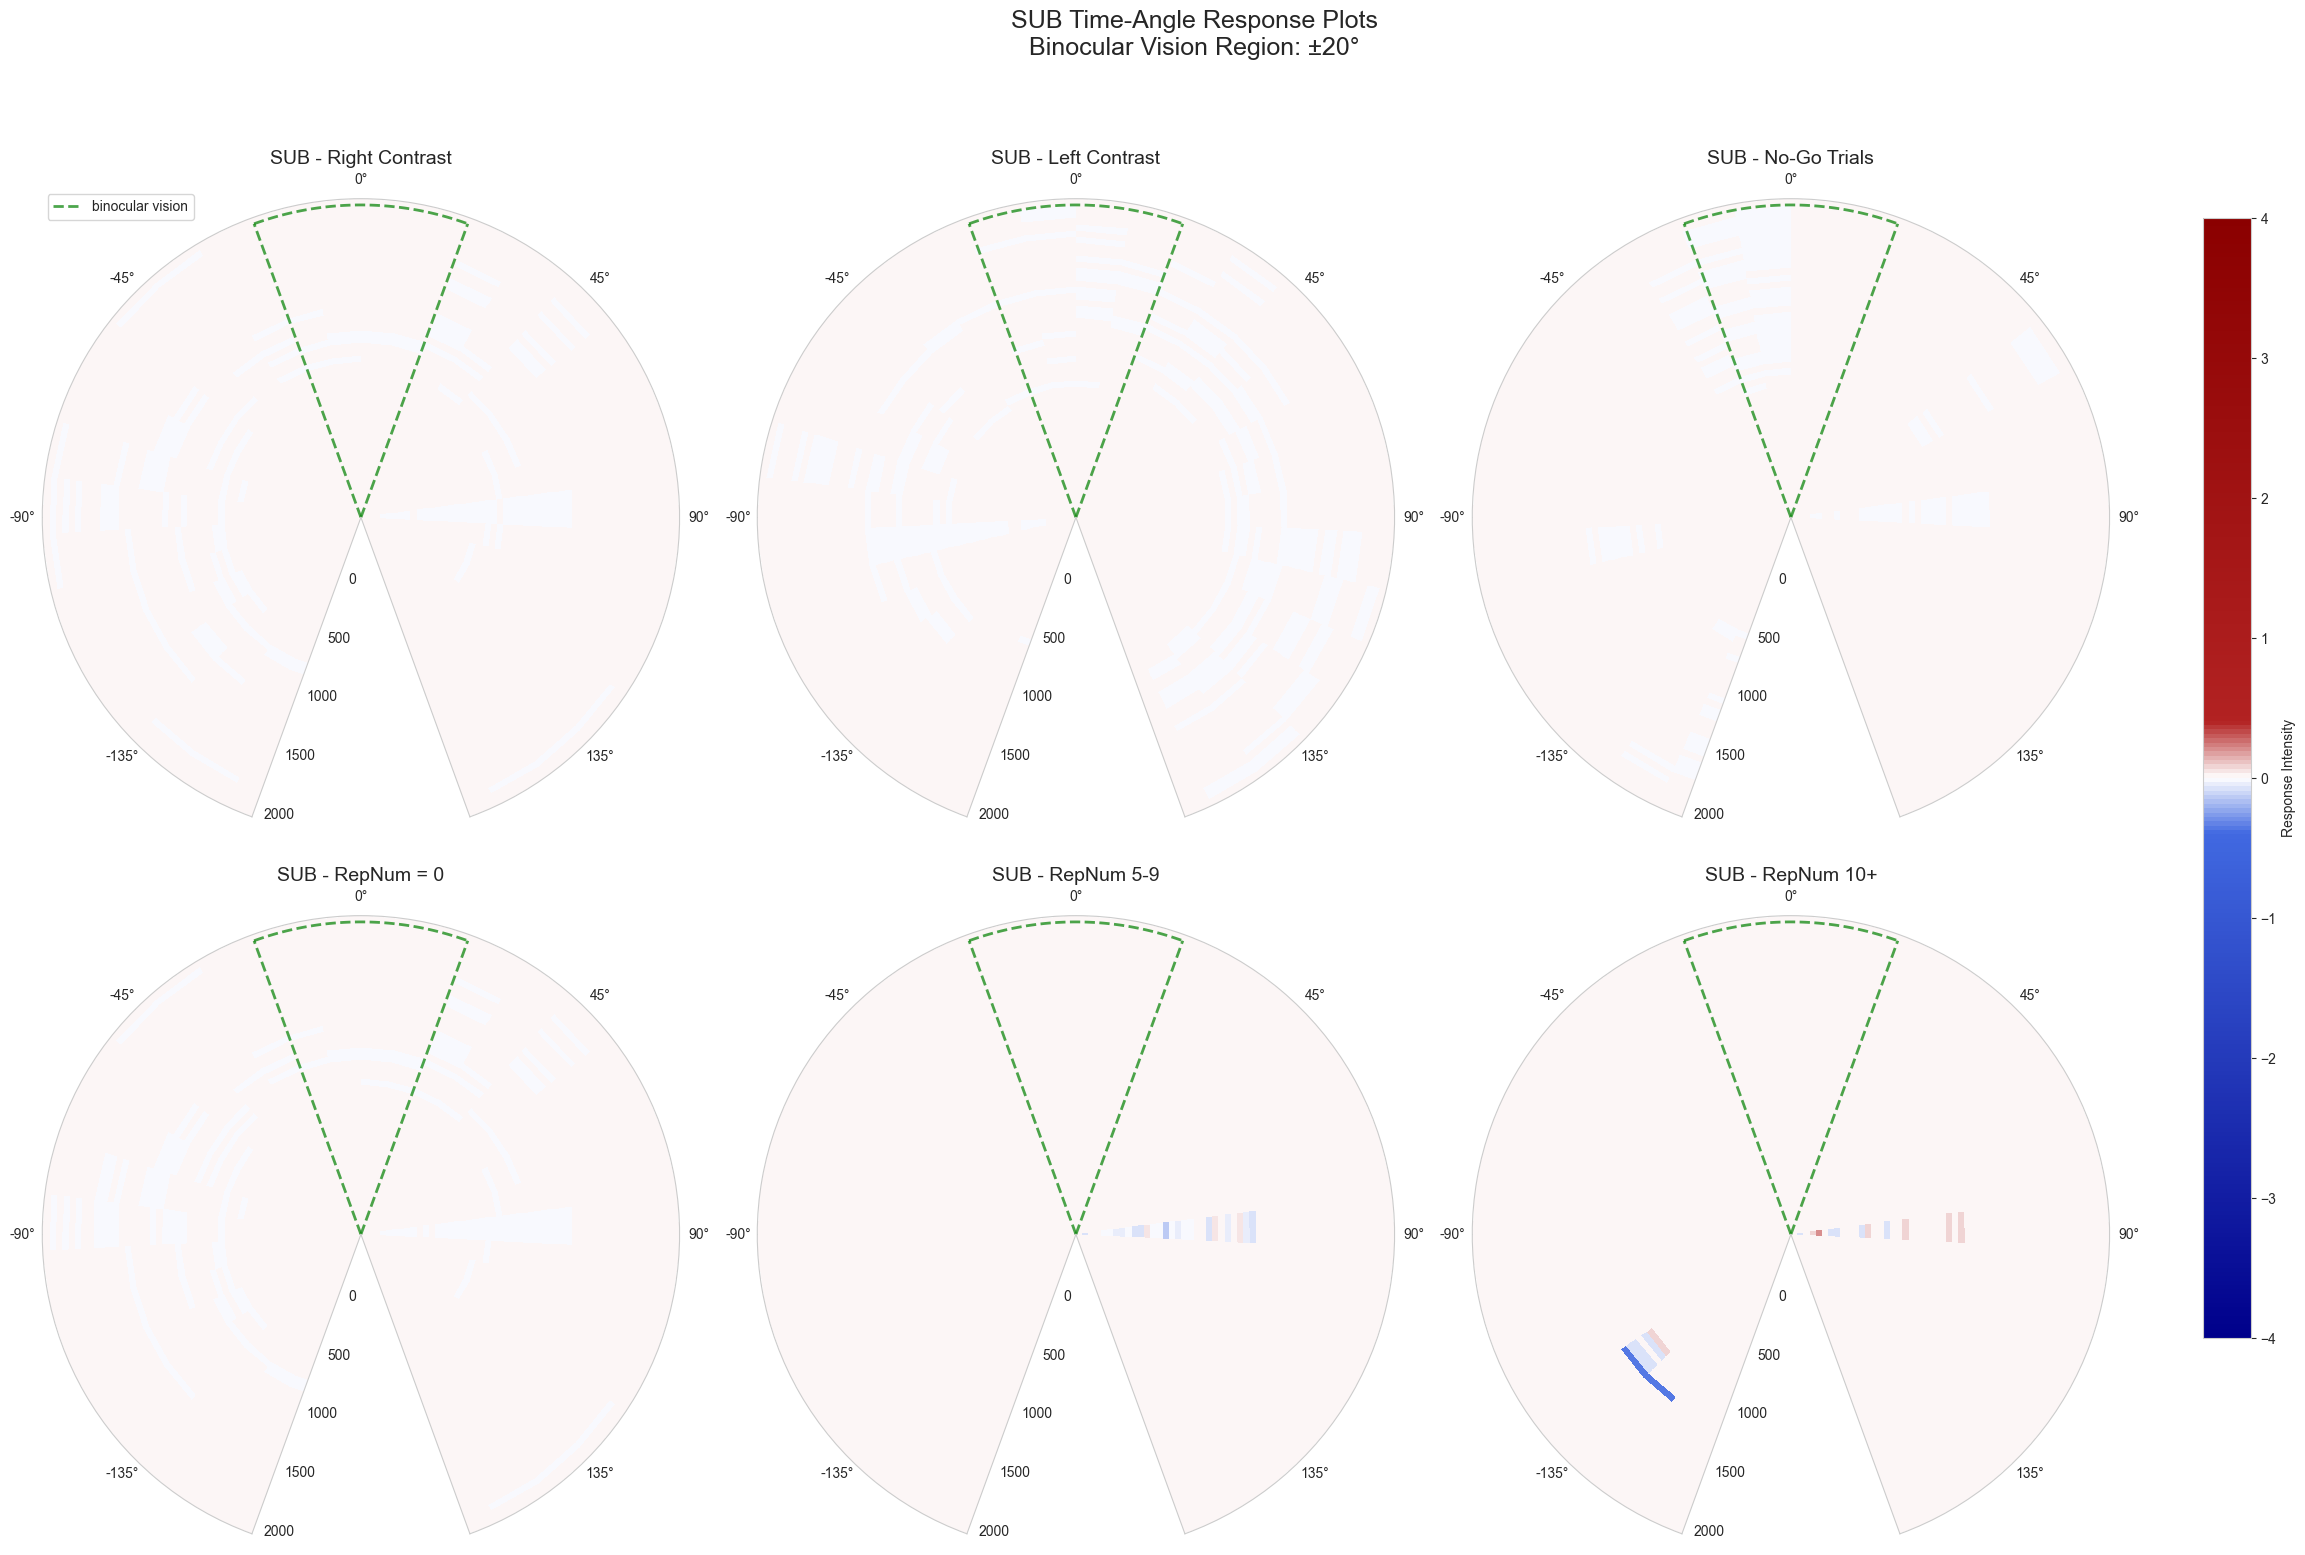

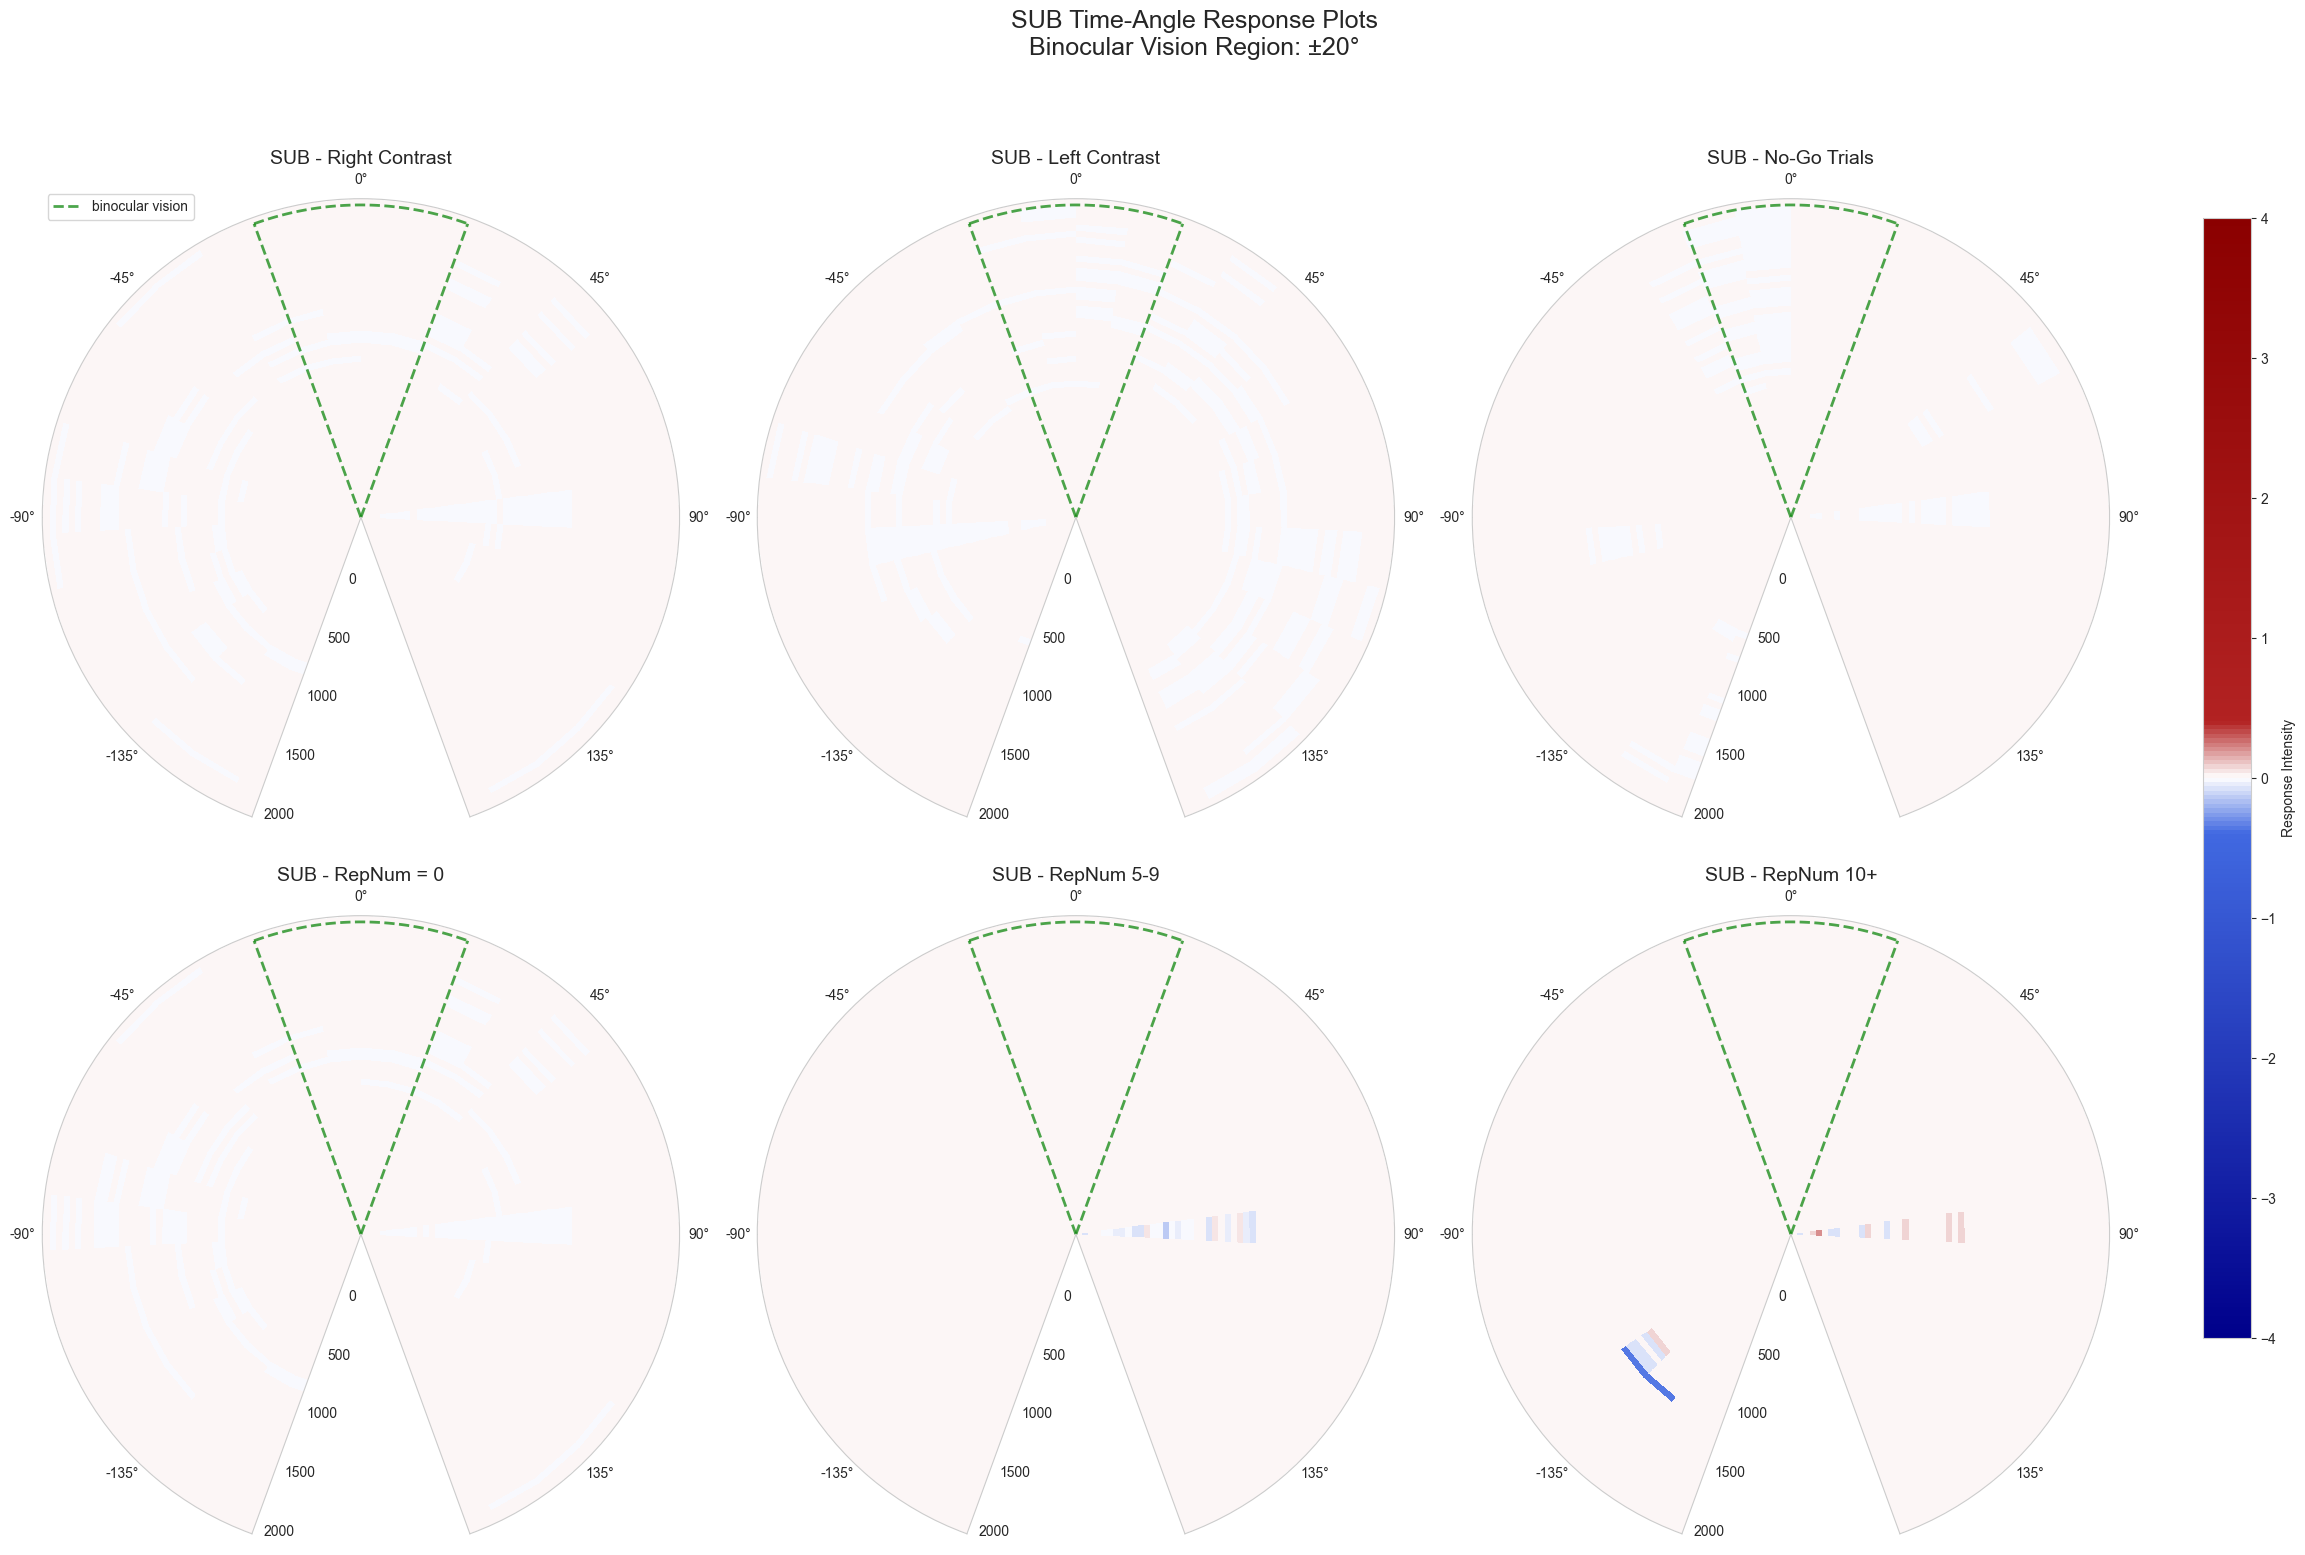

In [124]:
create_polar_subplots(df,'SUB')